# Домашнее задание №4

**Задание выполнил: Пешков Максим**

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [29]:
from tqdm import tqdm
import matplotlib.pyplot as plt

## Random Forest своими руками (4 балла)

Реализуйте алгоритм случайного леса. В соответствии с построением алгоритма, ваша реализация должна сочетать в себе метод бэггинга и метод случайных подмножеств. Также она должна работать для двух типов задач: как для задачи регрессии, так и для задачи классификации.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn`.*

In [2]:
class RandomForest:
    def __init__(self, n_estimators, max_depth, max_features='sqrt', 
                 task_type='regression', random_state=13):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        max_features - maximum features for each split in DecisionTree from sklearn
        task_type - 'regression' or 'classification'
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.task_type = task_type
        self.random_state = 13
        
        self.trees = None
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """        
        self.trees = []
        
        for i in range(self.n_estimators):
            idx = np.arange(len(X_train))
            # Используем бутстрап
            idx_chosen = np.random.choice(idx, size=len(X_train))
            X_bootstrap = X_train[idx_chosen, :]
            y_bootstrap = np.take(y_train, idx_chosen)
            
            if self.task_type == 'regression':
                # Обучаем дерево на случайном подмножестве признаков и закидываем его в список
                dtr = DecisionTreeRegressor(max_depth=self.max_depth, 
                                            max_features=self.max_features,
                                            random_state=self.random_state)
                
                dtr.fit(X_bootstrap, y_bootstrap)
                self.trees.append(dtr)
                
            else:
                # Обучаем дерево на случайном подмножестве признаков и закидываем его в список
                dtc = DecisionTreeClassifier(max_depth=self.max_depth, 
                                             max_features=self.max_features, 
                                             random_state=self.random_state)
                dtc.fit(X_bootstrap, y_bootstrap)
                self.trees.append(dtc)
                
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = np.zeros(len(X_test))
        
        for tree in self.trees:
            y_pred += tree.predict(X_test)
                
        y_pred = y_pred / len(self.trees)
        
        # Если перед нами задача классификации, то еще необходимо выбрать
        # самый частый ответ 
        if self.task_type == 'classification':
            y_pred = np.where(y_pred >= 0.5, 1, 0)
        
        return y_pred

Проверьте вашу реализацию на задаче регрессии. Подберите оптимальные гиперпараметры, чтобы получить MSE < 10.25 **(не меняйте параметры сида)**.

In [33]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [34]:
np.random.seed(19052019)
rf = RandomForest(n_estimators=1700, max_depth=100, max_features=6)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [35]:
print(f'MSE на контрольной выборке: {mean_squared_error(y_test, y_pred):.3}')

MSE на контрольной выборке: 9.21


In [36]:
np.random.seed(19052019)

scores = []

for n in tqdm(range(100, 2050, 25)):
    rf = RandomForest(n_estimators=n, max_depth=100, max_features=6)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scores.append(mean_squared_error(y_test, y_pred))

100%|██████████| 78/78 [01:40<00:00,  1.29s/it]


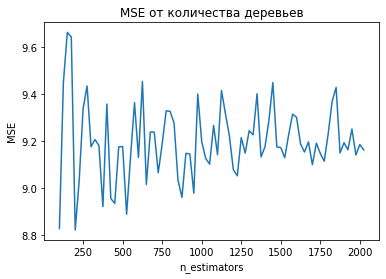

In [37]:
plt.title('MSE от количества деревьев')
plt.xlabel('n_estimators')
plt.ylabel('MSE')

plt.plot(np.arange(100, 2050, 25), scores);

Проверьте вашу реализацию на задаче классификации. Подберите оптимальные гиперпараметры, чтобы получить accuracy > 0.83 **(не меняйте параметры сида)**.

In [38]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [39]:
np.random.seed(19052019)
rf = RandomForest(n_estimators=1000, max_depth=100, max_features=6, task_type='classification')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [40]:
print(f'Доля правильных ответов на контрольной выборке: {accuracy_score(y_test, y_pred):.3}')

Доля правильных ответов на контрольной выборке: 0.958


## Градиентный бустинг своими руками (5 + 1* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Однако чтобы получить дополнительный 1 балл вам нужно реализовать нахождение оптимального $\gamma_N$ на каждом шаге.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [41]:
from scipy.optimize import minimize

In [43]:
def MSE(gamma, y):
    return np.mean((gamma * y[0] - y[1])**2)

In [44]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
        self.gamma = None
        self.composition_pred = None
        self.y_pred = None
        self.ensemble = None
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """
        self.composition_pred = np.zeros(len(X_train))
        self.ensemble = []
        
        for _ in range(self.n_estimators):
                dtr = DecisionTreeRegressor(max_depth=self.max_depth)
                
                # обучаем b_N модель на остатке s = y - a_{N-1} 
                dtr.fit(X_train, y_train - self.composition_pred)
                bN_pred_train = dtr.predict(X_train)
                
                # определяем оптимальный коэффициент гамма
                gamma_init = 0
                self.gamma = minimize(MSE, gamma_init, args=([bN_pred_train, 
                                                             y_train - self.composition_pred])).x[0]
                self.composition_pred += self.learning_rate * self.gamma * bN_pred_train
                
                # добавляем модель в ансамбль
                self.ensemble.append(dtr)
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        self.y_pred = np.zeros(len(X_test))
        
        for dtr in self.ensemble:
            bN_pred_test = dtr.predict(X_test)
            self.y_pred += self.learning_rate * self.gamma * bN_pred_test
        
        return self.y_pred

Проверьте вашу реализацию. Подберите оптимальные гиперпараметры, чтобы получить MSE < 10 как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**.

In [45]:
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [46]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=140, learning_rate=0.202, max_depth=6)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [47]:
mean_squared_error(y_test, y_pred)

9.461711118044638

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Ансамблевые методы (10 баллов)

Сопровождайте код изображениями и комментариями. Не игнорируйте вопросы, ваши выводы тоже оцениваются. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше. Не забывайте подписывать графики и будет вам счастье!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

**0. (0 баллов) ** Загрузите [датасет](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data), в нем вы найдете данные опрошенных женщин из индейского племени Пима. Будем решать задачу бинарной классификации: в колонке Outcome лежит метка наличия или отсутствия диабета - это наша целевая переменная. Есть ли пропущенные значения?

In [2]:
data = pd.read_csv('diabetes.csv')

In [3]:
data.isnull().any().any()

False

**1. (0.5 балла)** Как вы думаете, является ли наличие нулей в некоторых колонках фактом того, что эти признаки имеют пропущенные значения? Замените нули на среднее значение признака там, где считаете это целесообразным.

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Pregnancies - сколько раз были беременны, здесь 0 можно оставить, так как мужчины ведь не могут беременеть)))

Glucose - уровень глюкозы в крови, уровень 0 это очень плохо, поэтому здесь заменим

BloodPressure - давление, уровень 0 это плохо, тоже заменим

SkinThickness - уровень прослойки жира, тоже уровень 0 плохо, мы все в какой-то мере должны иметь слой сала (хохлы довольны)

Insulin - уровень инсулина, уровень 0 можно оставить, не все же постоянно на инсулине сидят

BMI - индекс веса, если 0, то как бы странно, это означает, что человек это пылинка, значит будем заменять

DiabetesPedigreeFunction - уровень диабета, уровень 0, говорит, что человек здоров, оставим

Age - возраст, мерить для младенца не будем, заменим на среднее

Outcome - бинарный признак, 0 оставим

In [5]:
l_col = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI','Age']
for col in l_col:
    data[col].replace(0, data[col].mean(), inplace=True)

In [6]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000000,148.0,72.0,35.000000,0,33.6,0.627,50,1
1,1.000000,85.0,66.0,29.000000,0,26.6,0.351,31,0
2,8.000000,183.0,64.0,20.536458,0,23.3,0.672,32,1
3,1.000000,89.0,66.0,23.000000,94,28.1,0.167,21,0
4,3.845052,137.0,40.0,35.000000,168,43.1,2.288,33,1


**2. (1 балл)** Визуализируйте распределение признаков по отдельности для больных диабетом и здоровых. Ваши графики должны быть примерно такими:

![Image](https://d.radikal.ru/d03/2005/f8/0ffb9443cbcf.png)

In [7]:
d_diab = data[data['Outcome'] == 1]
d_heal = data[data['Outcome'] == 0]

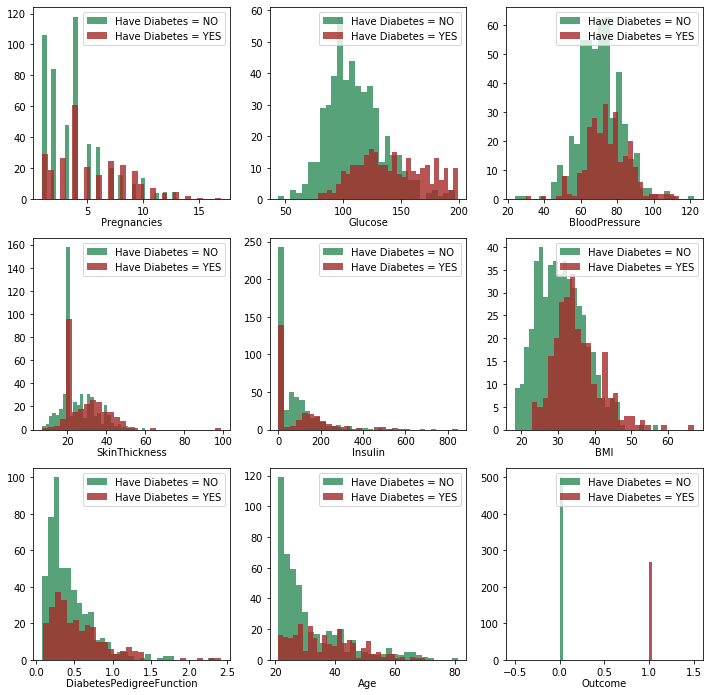

In [8]:
fig, ax = plt.subplots(3,3, figsize = (12,12))
i = 0
j = 0
for col in data.columns:
    h = i%3
    v = j%3
    ax[h, v].hist(d_heal[col], label = 'Have Diabetes = NO', color='seagreen', bins = 30, alpha=0.8)
    ax[h, v].hist(d_diab[col], label = 'Have Diabetes = YES', color='brown', bins = 30, alpha=0.8)
    ax[h, v].set_xlabel(col, labelpad=1,fontsize=10)
    ax[h, v].legend()
    j += 1
    if j % 3 == 0:
        i += 1

**3. (2 балла)** Разбейте данные на обучающую и тестовую часть в соотношении 70:30. Обучите `BaggingClassifier` на деревьях (поставьте параметр `'base_estimator' = DecisionTreeClassifier()`) и `RandomForest`. Возьмите количество базовых алгоритмов, равное 10. Посчитайте accuracy, recall и precision. Есть ли какая-то разница между моделями и их результатами? Как вы думаете, почему получились такие результаты?

*Подсказка: создайте отдельную функцию для вывода метрик качества.*

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [10]:
X = data.drop(['Outcome'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, data['Outcome'], test_size=0.3, random_state=13)

In [11]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state = 13),
    n_estimators=10)

In [12]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [13]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state = 13)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [14]:
print('Для Random Forest: \nAccuracy: {:} \nRecall: {:} \nPrecision: {:}'.format(accuracy_score(y_test, y_pred_rf), recall_score(y_test, y_pred_rf), precision_score(y_test, y_pred_rf)))

Для Random Forest: 
Accuracy: 0.7359307359307359 
Recall: 0.5057471264367817 
Precision: 0.7096774193548387


In [15]:
print('Для BaggingClassifier: \nAccuracy: {:} \nRecall: {:} \nPrecision: {:}'.format(accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)))

Для BaggingClassifier: 
Accuracy: 0.7619047619047619 
Recall: 0.5747126436781609 
Precision: 0.7352941176470589


**Вывод:** Существует разница между моделями: ансамбль по всем метрикам качества лучше

Такие результаты получились, потому что ансамбль получил больше информации (обучался по всем признакам), да и просто решающие деревья обычно хуже экстраполируются, если не подобрать гиперпараметры, и предсказывают (в тесте могут быть не похожие элементы)

**4. (2 балл)** Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров:
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Какие выводы вы можете сделать?

In [18]:
from sklearn.metrics import roc_auc_score

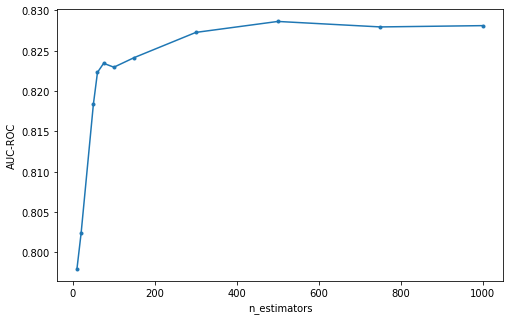

In [19]:
estimators = [10, 20, 50, 60, 75, 100, 150, 300, 500, 750, 1000]
quals_test = []
for n in estimators:
    dt =RandomForestClassifier(n_estimators=n, random_state=13)
    dt.fit(X_train, y_train)
    roc_test = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
    quals_test.append(roc_test)
    
plt.figure(figsize=(8, 5))
plt.plot(estimators, quals_test, marker='.')
plt.ylabel('AUC-ROC')
plt.xlabel('n_estimators')

plt.show()

**Вывод:** AUC-ROC растет до 400, а потом становится одинаковым, то есть дерево уже обучилось и увеличение n ни на что не влияет.

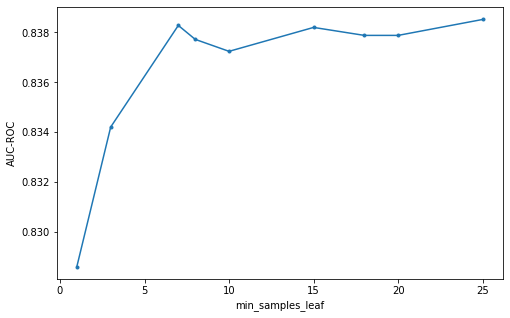

In [20]:
leaves = [25, 20, 18, 15, 10, 8, 7, 3, 1]
quals_test = []
for n in leaves:
    dt =RandomForestClassifier(n_estimators = 500, min_samples_leaf = n, random_state=13)
    dt.fit(X_train, y_train)
    roc_test = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
    quals_test.append(roc_test)
    
plt.figure(figsize=(8, 5))
plt.plot(leaves, quals_test, marker='.')
plt.ylabel('AUC-ROC')
plt.xlabel('min_samples_leaf')

plt.show()

**Вывод:** AUC-ROC растет до 7, а потом становится почти одинаковым, то есть дерево уже обучилось и увеличение минимального количества в листье ни на что не влияет.

**5. (1 балл)**. Посмотрите, оказались ли какие-то признаки более важными, чем остальные? Воспользуйтесь соответствующим атрибутом случайного леса в библиотеке `sklearn`, чтобы построить `barplot`.

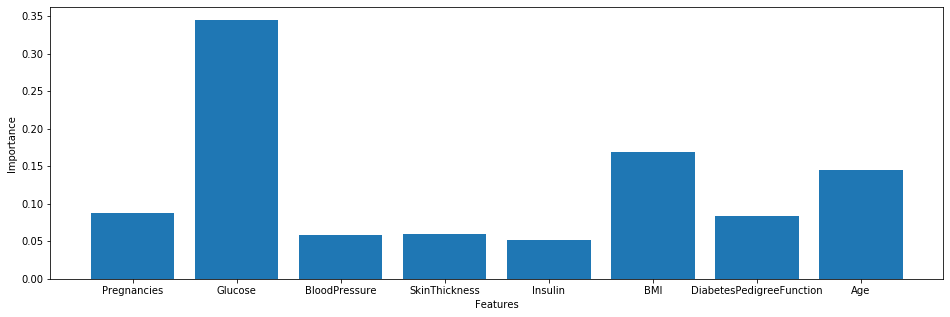

In [21]:
model = RandomForestClassifier(n_estimators = 500, min_samples_leaf = 7, random_state=13)
model.fit(X_train, y_train)
importance = model.feature_importances_
plt.subplots(figsize=(16, 5))
plt.bar(X_train.columns, importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Что логично, диабетики в основном с высоким уровнем глюкозы в крови

**6. (2 балла)** Обучите `HistGradientBoostingClassifier` и `GradientBoostingClassifier` из `sklearn`. Опишите подробно, в чем заключается разница этих моделей. Подберите подходящее количество деревьев и проанализируйте метрики, с которыми мы работали выше.

In [27]:
import sklearn.experimental

In [34]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm_notebook as tqdm

Разница в том, что HistGradientBoostingClassifier быстрее и лучше работаетдля больших датасетов. Более того, HistGradientBoostingClassifier может быстро распознавать NaN и поэтому быстрее делает градиентный спуск, а GradientBoostingClassifier старается обработать на каждом этапе функции потерь, что дает лучше качество, но медленнее

In [53]:
accuracy = []
for i in tqdm(range(1, 150)):
    clf = HistGradientBoostingClassifier(max_iter = i, random_state=13)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

In [54]:
accuracy.index(max(accuracy)) + 1 

32

In [55]:
clf = HistGradientBoostingClassifier(max_iter = 32)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Для HistGradientBoostingClassifier: \nAccuracy: {:} \nRecall: {:} \nPrecision: {:} \nAUC_ROC: {:}'.format(accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)))

Для HistGradientBoostingClassifier: 
Accuracy: 0.7619047619047619 
Recall: 0.5977011494252874 
Precision: 0.7222222222222222 
AUC_ROC: 0.7294061302681994


In [59]:
accuracy1 = []
for i in tqdm(range(1, 250)):
    clf = GradientBoostingClassifier(n_estimators = i, random_state=13)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy1.append(accuracy_score(y_test, y_pred))

In [60]:
accuracy1.index(max(accuracy1)) + 1 

111

In [61]:
clf = GradientBoostingClassifier(n_estimators = 111)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Для GradientBoostingClassifier: \nAccuracy: {:} \nRecall: {:} \nPrecision: {:} \nAUC_ROC: {:}'.format(accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)))

Для GradientBoostingClassifier: 
Accuracy: 0.7705627705627706 
Recall: 0.6206896551724138 
Precision: 0.7297297297297297 
AUC_ROC: 0.7409003831417624


**Вывод** И правда получили, что GradientBoostingClassifier по всем метрикам превосходит HistGradientBoostingClassifier, что было ожидаемо, так как у нас выборка небольшая и в ней нет пропусков

**7. (1.5 балла)** Вспомните, что представляет из себя стэкинг моделей. Возьмите в качестве базовых моделей любой ансамблевый метод из тех, которые были использованы выше, и простой классификатор из уже вами изученных на курсе. В качестве мета-классификатора (модели, обученной на ответах) используйте лог-регресссию. Посчитайте метрики для мета-классификатора. Улучшилось ли качество?

В данном пункте мы можете как написать код для стекинга сами, так и использовать [`StackingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier).

In [63]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [68]:
estimators = [RandomForestClassifier(n_estimators = 500, min_samples_leaf = 7), 
              GradientBoostingClassifier(n_estimators = 111),
             HistGradientBoostingClassifier(max_iter = 32)]
my_classifier = StackingClassifier(classifiers=estimators, meta_classifier=LogisticRegression(solver='lbfgs'))

In [69]:
my_classifier.fit(X_train, y_train)
y_pred3 = my_classifier.predict(X_test)
print('Для my_classifier: \nAccuracy: {:} \nRecall: {:} \nPrecision: {:} \nAUC_ROC: {:}'.format(accuracy_score(y_test, y_pred3), recall_score(y_test, y_pred3), precision_score(y_test, y_pred3), roc_auc_score(y_test, y_pred3)))

Для my_classifier: 
Accuracy: 0.7705627705627706 
Recall: 0.6206896551724138 
Precision: 0.7297297297297297 
AUC_ROC: 0.7409003831417624


**Вывод** Качество и правда улучшилось по всем метрикам, что свидетельствует о великой мощи стэкинга и ансамблей